In [1]:
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
print(y_train[0:5])

[5 0 4 1 9]


In [5]:
# convert using one hot encoding

print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [6]:
print("number of training examples:" , x_train.shape[0])
print("number of test examples:" , x_test.shape[0])

number of training examples: 60000
number of test examples: 10000


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

In [8]:
# showing an example of the Flatten class and operation
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

"original data shape"
print(x_train.shape)

"flattened shape"
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


In [9]:
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

print(W)
print()
print(b)

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>


In [10]:
def forward(x):
    return tf.matmul(x,W) + b

In [11]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with largest value (label assignment)
category 0


In [12]:
def activate(x):
    return tf.nn.softmax(forward(x))

In [13]:
def model(x):
    x = flatten(x)
    return activate(x)

In [14]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
# addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

138155.03

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

In [16]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        #compute loss function
        current_loss = cross_entropy( y, model(x))
        # compute gradient of loss 
        #(This is automatic! Even with specialized funcctions!)
        grads = tape.gradient( current_loss , [W,b] )
        # Apply SGD step to our Variables W and b
        optimizer.apply_gradients( zip( grads , [W,b] ) )     
    return current_loss.numpy()

In [17]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10],tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10],tf.float32))

loss_values=[]
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%500==0: #reporting intermittent batch statistics
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss) ) 
    
    # collecting statistics at each epoch...loss function and accuracy
    #  loss function
    current_loss = cross_entropy( y_train, model( x_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 

epoch  0 batch 500 loss: 176.88257
epoch  0 batch 1000 loss: 214.80328
end of epoch  0 loss 221839.72 accuracy 0.8149167
epoch  1 batch 500 loss: 206.1276
epoch  1 batch 1000 loss: 145.16835
end of epoch  1 loss 216982.12 accuracy 0.8226333
epoch  2 batch 500 loss: 169.53117
epoch  2 batch 1000 loss: 196.36026
end of epoch  2 loss 213829.17 accuracy 0.8272167
epoch  3 batch 500 loss: 172.28514
epoch  3 batch 1000 loss: 173.96254
end of epoch  3 loss 210430.03 accuracy 0.83066666
epoch  4 batch 500 loss: 161.20569
epoch  4 batch 1000 loss: 182.20525
end of epoch  4 loss 206470.05 accuracy 0.83503336
epoch  5 batch 500 loss: 190.57175
epoch  5 batch 1000 loss: 171.30872
end of epoch  5 loss 208921.95 accuracy 0.83255
epoch  6 batch 500 loss: 238.12854
epoch  6 batch 1000 loss: 199.50337
end of epoch  6 loss 206631.19 accuracy 0.8344167
epoch  7 batch 500 loss: 201.32297
epoch  7 batch 1000 loss: 186.5648
end of epoch  7 loss 203951.27 accuracy 0.83835
epoch  8 batch 500 loss: 186.96683
e

In [18]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train,axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1),tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.84003335
test accuracy 0.8326


Text(0, 0.5, 'loss')

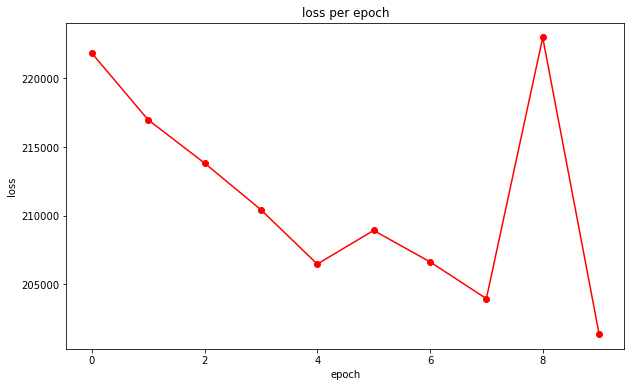

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

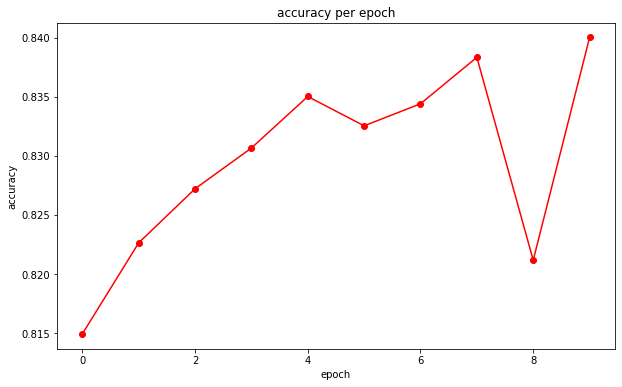

In [20]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

# 2nd part: Deep Learning applied on MNIST

In the first part, we learned how to use a simple ANN to classify MNIST. 
Now we are going to expand our knowledge using a Deep Neural Network.

Architecture of our network is:

(Input) -> [batch_size, 28, 28, 1] >> Apply 32 filter of [5x5]

(Convolutional layer 1) -> [batch_size, 28, 28, 32]

(ReLU 1) -> [?, 28, 28, 32]

(Max pooling 1) -> [?, 14, 14, 32]

(Convolutional layer 2) -> [?, 14, 14, 64]

(ReLU 2) -> [?, 14, 14, 64]

(Max pooling 2) -> [?, 7, 7, 64]

[fully connected layer 3] -> [1x1024]

[ReLU 3] -> [1x1024]

[Drop out] -> [1x1024]

[fully connected layer 4] -> [1x10]

The next cells will explore this new architecture.


The MNIST data¶

The MNIST Dataset will be used from the above example.

In [21]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

In [22]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])  
x_image_train = tf.cast(x_image_train, 'float32') 

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [23]:
# Reducing data size

# x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])
# y_train = tf.slice(y_train,[0,0],[10000, 10])

In [24]:
# Convolutional Layer 1
# Weights and Biases of kernels

W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

In [25]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

In [26]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

In [27]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

In [28]:
# Convolutional Layer 2
# Weights and Biases of kernels

W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

In [29]:
# Convolve image with weight tensor and add biases.

def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

In [30]:
# Apply the ReLU activation Function

def h_conv2(x):  return tf.nn.relu(convolve2(x))

In [31]:
# Apply the max pooling

def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

In [32]:
# Flattening Second Layer

def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

In [33]:
# Weights and Biases between layer 2 and 3

W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1, seed = 2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

In [34]:
# Matrix Multiplication (applying weights and biases)

def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

In [35]:
# Apply the ReLU activation Function

def h_fc1(x): return tf.nn.relu(fcl(x))

In [36]:
# Dropout Layer, Optional phase for reducing overfitting

keep_prob=0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

In [37]:
# Readout Layer (Softmax Layer)
# Weights and Biases

W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

In [38]:
# Matrix Multiplication (applying weights and biases)

def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

In [39]:
# Apply the Softmax activation Function
# softmax allows us to interpret the outputs of fcl4 as probabilities. 
# So, y_conv is a tensor of probabilities.

def y_CNN(x): return tf.nn.softmax(fc(x))

Summary of the Deep Convolutional Neural Network

Now is time to remember the structure of our network

0) Input - MNIST dataset

1) Convolutional and Max-Pooling

2) Convolutional and Max-Pooling

3) Fully Connected Layer

4) Processing - Dropout

5) Readout layer - Fully Connected

6) Outputs - Classified digits

In [40]:
# Define functions and train the model

import numpy as np
layer4_test =[[0.9, 0.1, 0.1],[0.9, 0.1, 0.1]]
y_test=[[1.0, 0.0, 0.0],[1.0, 0.0, 0.0]]
np.mean( -np.sum(y_test * np.log(layer4_test),1))

0.10536051565782628

In [41]:
#  Define the optimizer

optimizer = tf.keras.optimizers.Adam(1e-4)

In [42]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()

In [43]:
"""
results = []
increment = 1000
for start in range(0,60000,increment):
    s = tf.slice(x_image_train,[start,0,0,0],[start+increment-1, 28, 28, 1])
    t = y_CNN(s)
    #results.append(t)
"""

'\nresults = []\nincrement = 1000\nfor start in range(0,60000,increment):\n    s = tf.slice(x_image_train,[start,0,0,0],[start+increment-1, 28, 28, 1])\n    t = y_CNN(s)\n    #results.append(t)\n'

In [44]:
# Define prediction

correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

In [45]:
# Define accuracy

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

In [46]:
# Run session, train

loss_values=[]
accuracies = []
epochs = 1

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds2:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%50==0: #reporting intermittent batch statistics
            correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss),
                     "accuracy", str(accuracy)) 
            
    current_loss = cross_entropy( y_train, y_CNN( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) )  

epoch  0 batch 50 loss: 95.03221 accuracy 0.44
epoch  0 batch 100 loss: 52.944466 accuracy 0.68
epoch  0 batch 150 loss: 43.66124 accuracy 0.88
epoch  0 batch 200 loss: 23.346865 accuracy 0.78
epoch  0 batch 250 loss: 35.630066 accuracy 0.86
epoch  0 batch 300 loss: 14.671994 accuracy 0.74
epoch  0 batch 350 loss: 25.275866 accuracy 0.86
epoch  0 batch 400 loss: 17.958515 accuracy 0.94
epoch  0 batch 450 loss: 30.316656 accuracy 0.84
epoch  0 batch 500 loss: 15.313136 accuracy 0.96
epoch  0 batch 550 loss: 17.36241 accuracy 0.92
epoch  0 batch 600 loss: 18.033878 accuracy 0.88
epoch  0 batch 650 loss: 21.010431 accuracy 0.86
epoch  0 batch 700 loss: 6.649474 accuracy 1.0
epoch  0 batch 750 loss: 29.281334 accuracy 0.88
epoch  0 batch 800 loss: 10.358242 accuracy 0.9
epoch  0 batch 850 loss: 16.69586 accuracy 0.96
epoch  0 batch 900 loss: 13.293478 accuracy 0.92
epoch  0 batch 950 loss: 14.064144 accuracy 0.94
epoch  0 batch 1000 loss: 13.381055 accuracy 0.92
epoch  0 batch 1050 loss: 5

In [47]:
# Evaluate the model

j=0
accuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))            

batch 100 accuracy 0.94
batch 200 accuracy 0.96
batch 300 accuracy 0.92
batch 400 accuracy 0.96
batch 500 accuracy 0.94
batch 600 accuracy 0.92
batch 700 accuracy 0.98
batch 800 accuracy 0.96
batch 900 accuracy 0.88
batch 1000 accuracy 0.94
batch 1100 accuracy 0.88
batch 1200 accuracy 1.0
accuracy of entire set 0.93995


In [48]:
# Visualization

kernels = tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0,1]),[32, -1])

In [ ]:
import wget
# already imported below on the first run so commented it out
# wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py', 'utils1.py')

import utils1
import imp
imp.reload(utils1)
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Anthony\anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-0584c1460652>", line 1, in <module>
    import wget
ModuleNotFoundError: No module named 'wget'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Anthony\anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ModuleNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Anthony\anaconda3\envs\py36\lib\site-packages\IPython\core\ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Ant

ERROR! Session/line number was not unique in database. History logging moved to new session 308


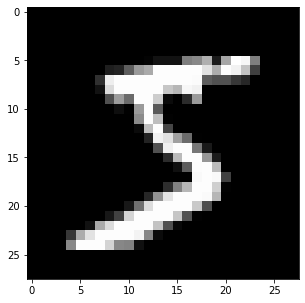

In [49]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

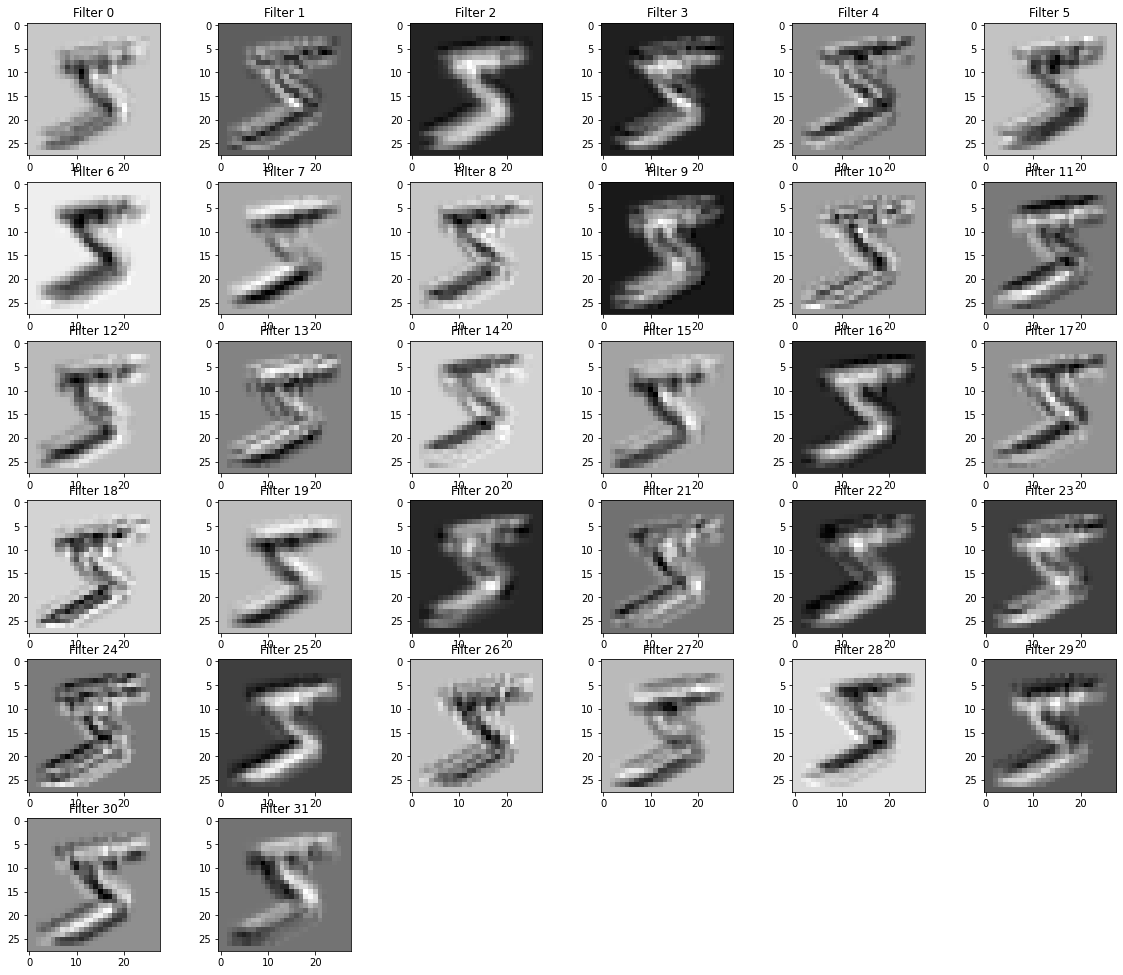

In [50]:
# ActivatedUnits = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})


keep_prob=1.0
ActivatedUnits = convolve1(sampleimage)

filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

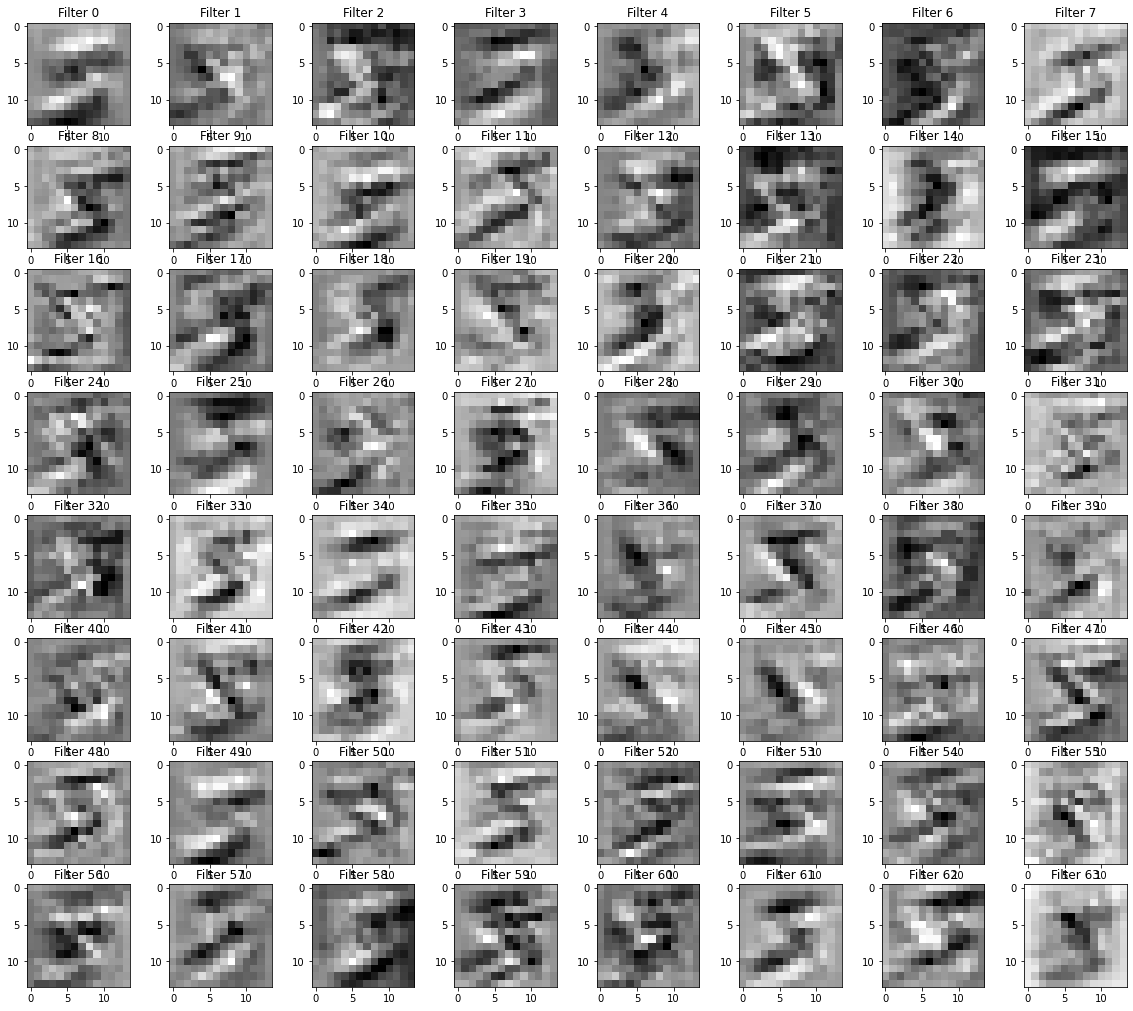

In [51]:
#ActivatedUnits = sess.run(convolve2,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})

ActivatedUnits = convolve2(sampleimage)

filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")